In [1]:
import pandas as pd
import numpy as np
import glob
import os
import cv2
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Activation, MaxPool2D, Input, Conv2DTranspose, UpSampling2D, Concatenate
from tensorflow.keras import activations
from tensorflow.keras import backend as K

In [2]:
print([tf.__version__, tf.test.is_gpu_available()])
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


['2.4.1', True]
Num GPUs Available:  1


In [3]:
IMG_MASK_DIR = '../input/bacteria-detection-with-darkfield-microscopy/'
IMAGE_DIR_PATH = IMG_MASK_DIR + 'images/'
MASK_DIR_PATH = IMG_MASK_DIR + 'masks/'

N_CLASSES = 3
N_CHANNELS = 3
N_IMAGES = len(os.listdir(IMAGE_DIR_PATH))

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

BATCH_SIZE = 16 # * tpu_strategy.num_replicas_in_sync

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
img_msk_indexes = os.listdir(IMAGE_DIR_PATH)
img_msk_indexes[:5]

['173.png', '043.png', '248.png', '038.png', '069.png']

### Split data to train/val/test

In [5]:
def split(train_size=0.7, val_size=0.15):
    assert train_size + val_size < 1
    
    test_size = 1 - train_size + val_size
    
    img_msk_indexes = os.listdir(IMAGE_DIR_PATH)
    random.shuffle(img_msk_indexes)
    
    n = len(img_msk_indexes)
    
    train_fnames = img_msk_indexes[:int(n*train_size)]
    val_fnames = img_msk_indexes[int(n*train_size):int(n*(val_size + train_size))]
    test_fnames = img_msk_indexes[int(n*(val_size + train_size)):]
    
    return train_fnames, val_fnames, test_fnames

train_fnames, val_fnames, test_fnames = split(train_size=0.8, val_size=0.1)

In [6]:
print(val_fnames[:5])
print(test_fnames[:5])

['023.png', '070.png', '323.png', '015.png', '017.png']
['309.png', '034.png', '102.png', '264.png', '005.png']


### Loading data as tf.data.Dataset

In [7]:
# def make_dataset(train_size: float=0.8, val_size: float=0.1, test_size: float=0.1):
#     """Loads data from images, masks directories, then splits into 
    
#     If arguments are not passed, the default train/val/test sizes are used - (80/10/10)%
    
#     Returns
#     -------
#     Training, validation and test datasets that consists of zipped loaded images and masks.
#     """
#     assert train_size + val_size + test_size == 1
    
#     def parse_image(filename):
#         image = tf.io.read_file(filename)
#         image = tf.image.decode_png(image, channels=N_CHANNELS)
#         image = tf.image.resize(image, size=(IMG_HEIGHT, IMG_WIDTH))
#         image = tf.cast(image / 255., tf.float32)
        
#         return image
    
#     def parse_mask(filename):
#         mask = tf.io.read_file(filename)
#         mask = tf.image.decode_png(mask, channels=1)
#         mask = tf.image.resize(mask, size=(IMG_HEIGHT, IMG_WIDTH))
#         mask = tf.one_hot(tf.cast(mask, tf.int32), N_CLASSES)
#         mask = tf.reshape(mask, (IMG_HEIGHT, IMG_WIDTH, N_CLASSES))

#         return mask
    
#     def parse_img_mask(fimg, fmask):
#         image = parse_image(fimg)
#         mask = parse_mask(fmask)
    
#         return image, mask
    
#     def split(ds):
#         ds = ds.shuffle(buffer_size=N_IMAGES, reshuffle_each_iteration=False, seed=3)
    
#         train_size_int = int(train_size * N_IMAGES)

#         train_ds = ds.take(train_size_int)
#         test_ds = ds.skip(train_size_int)
#         val_ds = test_ds.skip(int(val_size * N_IMAGES))
#         test_ds = test_ds.take(int(test_size * N_IMAGES))
        
#         return train_ds, val_ds, test_ds
    
#     with tf.device('/cpu:0'):
#         img_filenames_ds = tf.data.Dataset.list_files(str(IMAGE_DIR_PATH + '*.png'), shuffle=False)
#         images_ds = img_filenames_ds.map(parse_image, num_parallel_calls=AUTOTUNE)

#         mask_filenames_ds = tf.data.Dataset.list_files(str(MASK_DIR_PATH + '*.png'), shuffle=False)
#         masks_ds = mask_filenames_ds.map(parse_mask, num_parallel_calls=AUTOTUNE)
#         ds = tf.data.Dataset.zip((images_ds, masks_ds))
        
#         train_ds, val_ds, test_ds = split(ds)
    
#         return train_ds, val_ds, test_ds

In [8]:
def make_dataset(fnames):
    """Loads data from images, masks directories, then splits into 
    
    If arguments are not passed, the default train/val/test sizes are used - (80/10/10)%
    
    Returns
    -------
    Training, validation and test datasets that consists of zipped loaded images and masks.
    """
    
    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_png(image, channels=N_CHANNELS)
        image = tf.image.resize(image, size=(IMG_HEIGHT, IMG_WIDTH))
        image = tf.cast(image / 255., tf.float32)
        
        return image
    
    def parse_mask(filename):
        mask = tf.io.read_file(filename)
        mask = tf.image.decode_png(mask, channels=1)
        mask = tf.image.resize(mask, size=(IMG_HEIGHT, IMG_WIDTH))
        mask = tf.one_hot(tf.cast(mask, tf.int32), N_CLASSES)
        mask = tf.reshape(mask, (IMG_HEIGHT, IMG_WIDTH, N_CLASSES))

        return mask
    
    def concat_fnames(target_dir):
        return list(map(lambda x: target_dir + x, fnames))
    
    with tf.device('/cpu:0'):
        img_fnames = concat_fnames(IMAGE_DIR_PATH)
        msk_fnames = concat_fnames(MASK_DIR_PATH)

        img_filenames_ds = tf.data.Dataset.from_tensor_slices(img_fnames)
        images_ds = img_filenames_ds.map(parse_image, num_parallel_calls=AUTOTUNE)

        msk_filenames_ds = tf.data.Dataset.from_tensor_slices(msk_fnames)
        masks_ds = msk_filenames_ds.map(parse_mask, num_parallel_calls=AUTOTUNE)
        ds = tf.data.Dataset.zip((images_ds, masks_ds))
        
    
    return ds

In [9]:
tf.__version__

'2.4.1'

In [10]:
train_ds = make_dataset(train_fnames)
val_ds = make_dataset(val_fnames)
test_ds = make_dataset(test_fnames)
print(train_ds)
print(f'Train: {train_ds.cardinality()}\nVal: {val_ds.cardinality()}\nTest: {test_ds.cardinality()}')

<ZipDataset shapes: ((256, 256, 3), (256, 256, 3)), types: (tf.float32, tf.float32)>
Train: 292
Val: 37
Test: 37


### Calculating loss weights

In [11]:
def get_loss_weights(masks: tf.Tensor):
    loss_weights = {
        0: 0,
        1: 0,
        2: 0
    }
        
    for j, mask in enumerate(masks.as_numpy_iterator()):
        tmp = tf.argmax(mask, axis=-1).numpy()
        _, counts = np.unique(tmp, return_counts=True)

        for i in range(len(counts)):
            loss_weights[i] += counts[i]
    total_counts = sum(loss_weights.values())
    print(loss_weights, total_counts)

    for key, v in loss_weights.items():
        loss_weights[key] = total_counts / v

    return loss_weights

In [12]:
mask = train_ds.map(lambda a, b: b)
loss_weights = get_loss_weights(mask)

w = [[loss_weights[0], loss_weights[1], loss_weights[2]]] * IMG_WIDTH
h = w * IMG_HEIGHT

loss_mod = np.array(h)
loss_mod

{0: 16140317, 1: 2810208, 2: 185987} 19136512


array([[  1.18563421,   6.80964256, 102.89166447],
       [  1.18563421,   6.80964256, 102.89166447],
       [  1.18563421,   6.80964256, 102.89166447],
       ...,
       [  1.18563421,   6.80964256, 102.89166447],
       [  1.18563421,   6.80964256, 102.89166447],
       [  1.18563421,   6.80964256, 102.89166447]])

### Data preparation

At the beginning tf.data.Datasets are shuffled and repeated. 

**Training** samples:
* augmented
* batched
* prefetched  

**Validation** samples:
* batched
* prefetched

In [13]:
def prepare_data(ds: tf.Tensor, augment: bool=False, color_augmentation: bool=False):
    """Preparing data for training 
    
    Parameters 
    ----------
    ds : tf.Tensor 
        The dataset tensor that will be processed
    augment : bool, optional
        Whether the given dataset will be augmented. By default no autgmentation 
    color_augmentation: bool, optional
        Whether the color augmentation will be performed. 
        Augment argument has to be True 
        
    Return
    ------
    Processed and batched dataset
    """    
    
    if color_augmentation is True:
        assert augment is True
    
    def color(img: tf.Tensor, seed):
        """Function which performs color augmentation"""
        
        img = tf.image.stateless_random_hue(img, 0.08, seed)
        img = tf.image.stateless_random_saturation(img, 0, 0.4, seed)
        img = tf.image.stateless_random_brightness(img, 0.05, seed)
        img = tf.image.stateless_random_contrast(img, 0, 0.4, seed)
        
        return img
    
    def f(img, msk):
        """A wrapper function for updating seeds"""
        seed = rng.make_seeds(2)[0]
        image, mask = augment((img, msk), seed)
        
        return image, mask
        
    def augment(image_mask, seed):
        """
        Augmenting provided image and mask by performing 90-degrees rotation and flipping vertically and horizontaly
        
        If color_augmentation is False then performing only 90-degrees rotations and flipping.
        Color augmentation only affects images, it is not applied to masks.
        """
        image, mask = image_mask
        
        # rotating
        rotation = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, rotation)
        mask = tf.image.rot90(mask, rotation)
        
        # fliping vertically
        image = tf.image.stateless_random_flip_left_right(image, seed)
        mask = tf.image.stateless_random_flip_left_right(mask, seed)
        
        #flipping horizontaly
        image = tf.image.stateless_random_flip_up_down(image, seed)
        mask = tf.image.stateless_random_flip_up_down(mask, seed)
        
        image = tf.image.resize(tf.image.stateless_random_crop(image, (128, 128, 3), seed=seed), (IMG_HEIGHT, IMG_WIDTH))
        mask = tf.image.resize(tf.image.stateless_random_crop(mask, (128, 128, 3), seed=seed), (IMG_HEIGHT, IMG_WIDTH))
        
        if color_augmentation is True:
            # applying color augmentation
            image = color(image, seed)
        
        return image, mask

    rng = tf.random.Generator.from_seed(123, alg='philox')
    
#     with tf.device('/cpu:0'):
    ds = ds.shuffle(N_IMAGES).repeat()
    if augment == True:
        ds = ds.map(f, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
        
    return ds

In [14]:
train_ds = prepare_data(train_ds, augment=True, color_augmentation=False)
val_ds = prepare_data(val_ds)
test_ds = prepare_data(test_ds)

#### Visualization of 6 images and masks from test data set.

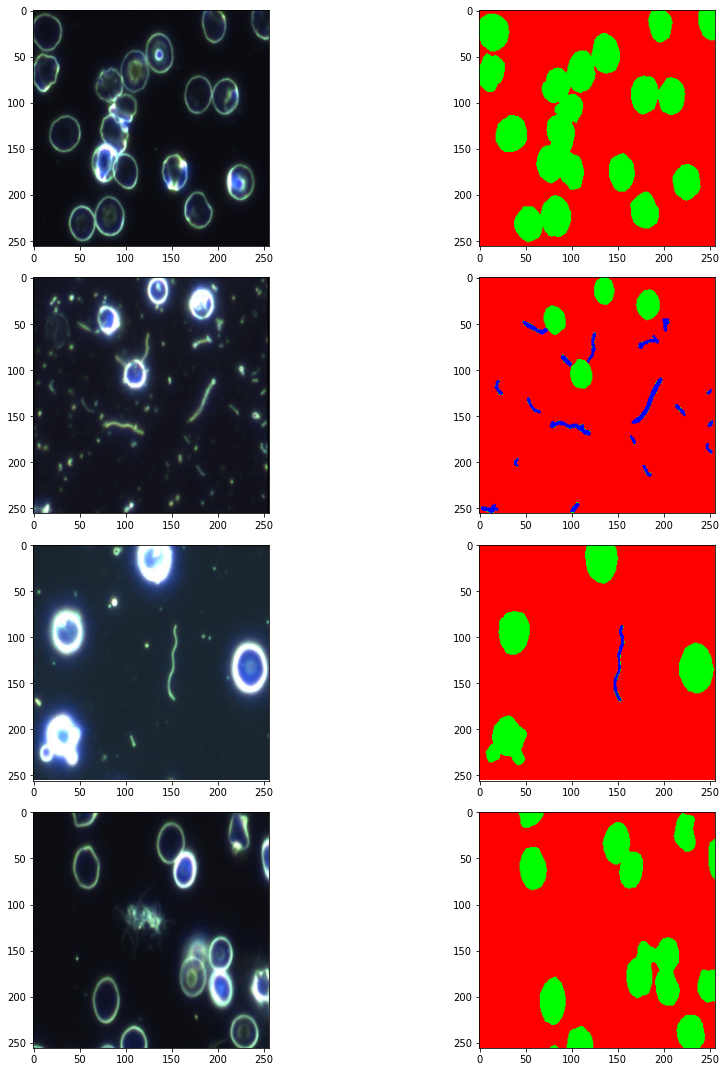

In [15]:
fig,axes = plt.subplots(4, 2, figsize=(15,15))
batched_ds = test_ds.take(1)
imgs, msks = next(batched_ds.as_numpy_iterator())

for i in range(len(imgs)):
    if i == 4:
        break
    axes[i,0].imshow(imgs[i])
    axes[i,1].imshow(msks[i])
    
plt.tight_layout()

#### Visualization of augmented data from trainning set

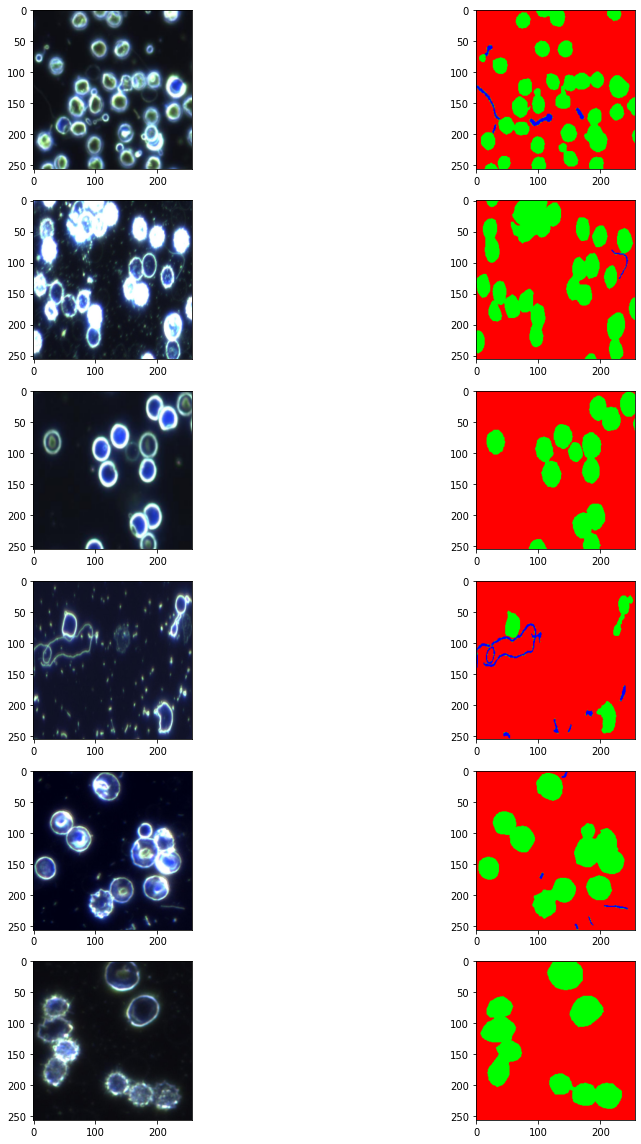

In [16]:
with tf.device('/cpu:0'):
    tmp_train = train_ds.take(1)
    
    a, b = next(iter(tmp_train))
        
    fig, axes = plt.subplots(6, 2, figsize=(16,16))

    for i in range(6):
        axes[i,0].imshow(a[i])
        axes[i,1].imshow(b[i])
    plt.tight_layout()

## Metrics

The Intersection-Over-Union (IoU) in one of the most commonly used metrics in semantic segmentation.

$$ 
IoU = \frac{Area Of Overlap}{Area Of Union}
$$

In [17]:
@tf.function
def IoU(labels, predictions, smooth=1):
    intersection = K.sum(K.abs(predictions * labels), axis=[1,2,3])
    union = K.sum(labels, axis=[1,2,3]) + K.sum(predictions, axis=[1,2,3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou


def f1_score(y_true, y_pred):

    intersection = tf.reduce_sum( y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    return (2*intersection) / denominator


In [18]:
def dice_coef(labels, predictions, smooth=1):
    intersection = K.sum(predictions * labels, axis=[1,2,3])
    union = K.sum(labels, axis=[1,2,3]) + K.sum(predictions, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice

@tf.function
def dice_loss(labels, predictions, smooth=1):
    intersection = K.sum(predictions * labels, axis=[1,2,3])
    union = K.sum(labels, axis=[1,2,3]) + K.sum(predictions, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return 1-dice

In [19]:
def jaccard_loss(y_true, y_pred, smooth=100.0):
    """
    Arguments:
        y_true : Matrix containing one-hot encoded class labels 
                 with the last axis being the number of classes.
        y_pred : Matrix with same dimensions as y_true.
        smooth : smoothing factor for loss function.
    """

    intersection = tf.reduce_sum( y_true * y_pred, axis=-1)
    union = tf.reduce_sum(y_true + y_pred, axis=-1) - intersection
    jac = (intersection + smooth) / (union + smooth)
    
    return (1 - jac) * smooth

### Model archutecture that will be used is Unet alike architecture.
[Unet paper source](https://arxiv.org/abs/1505.04597)

In [20]:
def conv2d_block(input_tensor, n_filters: int, kernel_size: int=3, batchnorm: bool=True):
    """
    Function that creates 2 convolutional layers with given parameters
    """
    
    # First layer
    c_1 = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02))(input_tensor)
    if batchnorm:
        c_1 = BatchNormalization()(c_1)
    c_1 = Activation(activations.relu)(c_1)
    
    # Seconds layer
    c_2 = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02))(c_1)
    if batchnorm:
        c_2 = BatchNormalization()(c_2)
    c_2 = Activation(activations.relu)(c_2)
    
    return c_2

In [21]:
dropout = 0.2
filters = 32


inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS))
kernel_size = 5

# Downsampling
c1 = conv2d_block(inputs, filters, kernel_size)
p1 = MaxPool2D((2,2))(c1)
# p1 = Dropout(dropout)(p1)

c2 = conv2d_block(p1, filters * 2, kernel_size)
p2 = MaxPool2D((2,2))(c2)
# p2 = Dropout(dropout)(p2)

c3 = conv2d_block(p2, filters * 4, kernel_size)
p3 = MaxPool2D((2,2))(c3)
# p3 = Dropout(dropout)(p3)

c4 = conv2d_block(p3, filters * 8, kernel_size)
p4 = MaxPool2D((2,2))(c4)
# p4 = Dropout(dropout)(p4)

c5 = conv2d_block(p4, filters * 16, kernel_size)

# Upsampling
u6 = Conv2DTranspose(filters * 8, (kernel_size, kernel_size), strides=(2,2), padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02))(c5)
u6 = Concatenate()([u6, c4])
# u6 = Dropout(dropout)(u6)
c6 = conv2d_block(u6, filters * 8, kernel_size)

u7 = Conv2DTranspose(filters * 4, (kernel_size, kernel_size), strides=(2,2), padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02))(c6)
u7 = Concatenate()([u7, c3])
# u7 = Dropout(dropout)(u7)
c7 = conv2d_block(u7, filters * 4, kernel_size)

u8 = Conv2DTranspose(filters * 2, (kernel_size, kernel_size), strides=(2,2), padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02))(c7)
u8 = Concatenate()([u8, c2])
# u8 = Dropout(dropout)(u8)
c8 = conv2d_block(u8, filters * 2, kernel_size)

u9 = Conv2DTranspose(filters, (kernel_size, kernel_size), strides=(2,2), padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02))(c8)
u9 = Concatenate()([u9, c1])
# u9 = Dropout(dropout)(u9)
c9 = conv2d_block(u9, filters, kernel_size)
c9 = Dropout(0.5)(c9)

outputs = Conv2D(3, (1,1), activation=activations.softmax)(c9)
model = keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3),
         loss=jaccard_loss,
         metrics=['accuracy', f1_score])

In [22]:
# tf.keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 2432        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Model training

In [23]:
steps_per_epoch = 3 * 0.8 * N_IMAGES // BATCH_SIZE 
validation_steps = 3 * 0.1 * N_IMAGES // BATCH_SIZE

# es = tf.keras.callbacks.EarlyStopping(
#     monitor='val_IoU', min_delta=0.002, patience=5, verbose=1,
#     mode='max'
# )

mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_f1_score', mode='max', verbose=1)

model_history = model.fit(
    train_ds,
    epochs=45,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=6,
    verbose=2)

Epoch 1/45
54/54 - 36s - loss: 0.5836 - accuracy: 0.8366 - f1_score: 0.7037 - val_loss: 1.6821 - val_accuracy: 0.1421 - val_f1_score: 0.1421
Epoch 2/45
54/54 - 23s - loss: 0.3581 - accuracy: 0.9074 - f1_score: 0.8182 - val_loss: 0.3800 - val_accuracy: 0.8672 - val_f1_score: 0.8069
Epoch 3/45
54/54 - 22s - loss: 0.2579 - accuracy: 0.9214 - f1_score: 0.8690 - val_loss: 0.3349 - val_accuracy: 0.8522 - val_f1_score: 0.8295
Epoch 4/45
54/54 - 22s - loss: 0.1958 - accuracy: 0.9323 - f1_score: 0.9005 - val_loss: 0.3166 - val_accuracy: 0.8517 - val_f1_score: 0.8387
Epoch 5/45
54/54 - 22s - loss: 0.1528 - accuracy: 0.9430 - f1_score: 0.9223 - val_loss: 0.2945 - val_accuracy: 0.8537 - val_f1_score: 0.8498
Epoch 6/45
54/54 - 22s - loss: 0.1435 - accuracy: 0.9410 - f1_score: 0.9270 - val_loss: 0.2490 - val_accuracy: 0.8784 - val_f1_score: 0.8731
Epoch 7/45
54/54 - 22s - loss: 0.1235 - accuracy: 0.9478 - f1_score: 0.9371 - val_loss: 0.2334 - val_accuracy: 0.8836 - val_f1_score: 0.8810
Epoch 8/45
54

In [24]:
# model = tf.saved_model.load("Unet.h5")

In [25]:
test = test_ds.take(2)

# j = 0
# for i in test.as_numpy_iterator():
#     fig,axes=plt.subplots(1,2)
#     axes[0].imshow(i[0][0])
#     axes[1].imshow(i[1][0])
#     if j == 6: break
#     j += 1
    
results = model.evaluate(test)


2/2 [==============================] - 2s 237ms/step - loss: 0.0492 - accuracy: 0.9750 - f1_score: 0.9749


In [26]:
train_ds.take(1).cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=1>

In [27]:
def binary_rgb(img, label, pred, visualize=True): 
    copy_pred = pred.copy()
    copy_label = label.copy()
    
    decoded_pred = np.argmax(copy_pred, axis=2)
    decoded_label = np.argmax(copy_label, axis=2)
    
    blank_pred = np.zeros(shape=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS), dtype='float32')
    blank_pred[decoded_pred == 1] = [1,0,0]
    blank_pred[decoded_pred == 0] = [0,0,0]
    blank_pred[decoded_pred == 2] = [1,1,0]
    
    if visualize:
        fig, axes = plt.subplots(1, 3, figsize=(15, 15))
        
        copy_label = cv2.cvtColor(copy_label, cv2.COLOR_RGB2BGR)
        

        pred_over_label = cv2.bitwise_xor(copy_label, blank_pred)
        dst = cv2.addWeighted(img, 0.8, blank_pred, 0.3, 0)

        axes[0].imshow(dst)
        axes[0].set_title('Prediction over image')
        
        axes[1].imshow(pred)
        axes[1].set_title('Prediction')
        
        axes[2].imshow(label)
        axes[2].set_title('Ground Truth')
    
    return blank_pred

In [28]:
tmp_test = test.take(1)
iterator = test.as_numpy_iterator()# tmp_img = next(tmp_test.as_numpy_iterator())

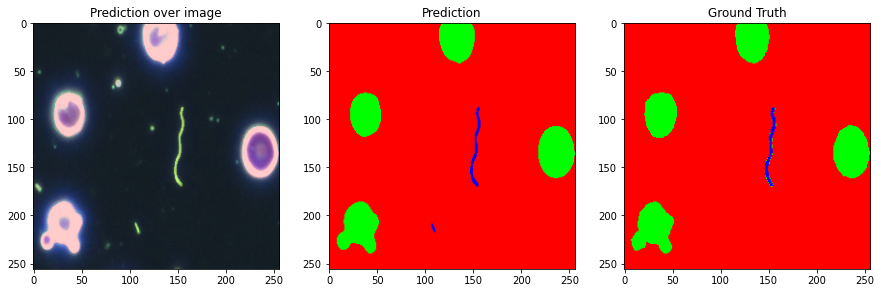

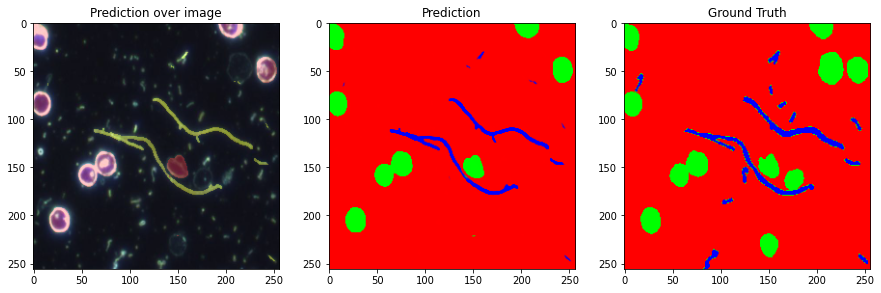

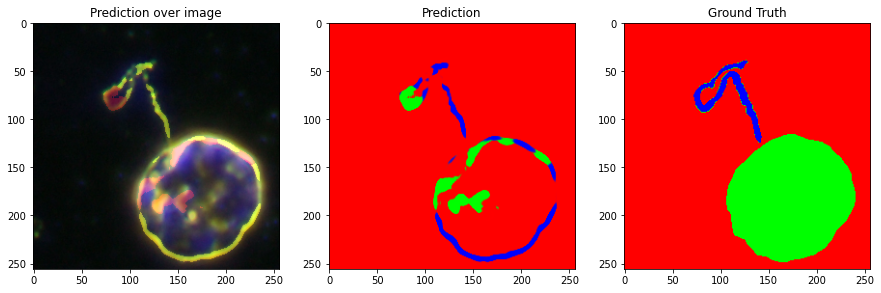

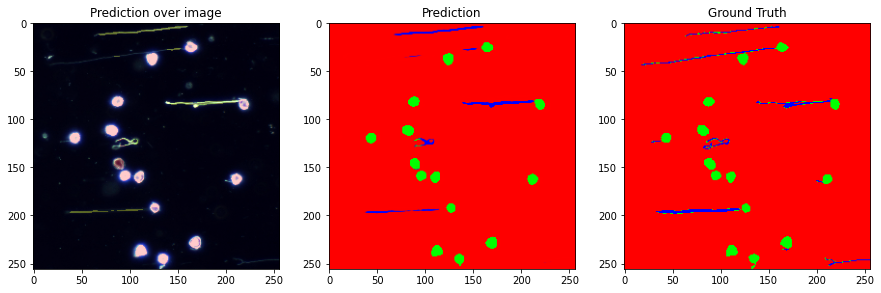

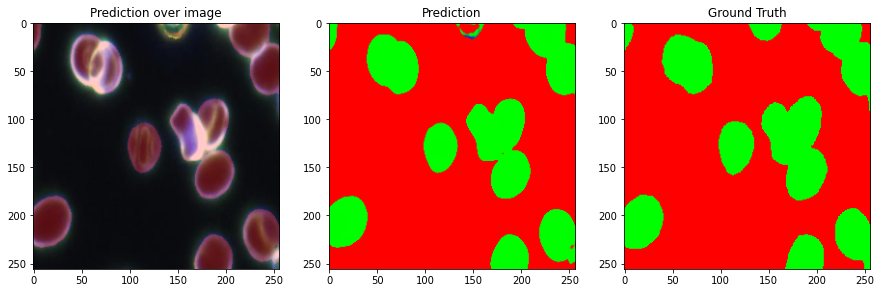

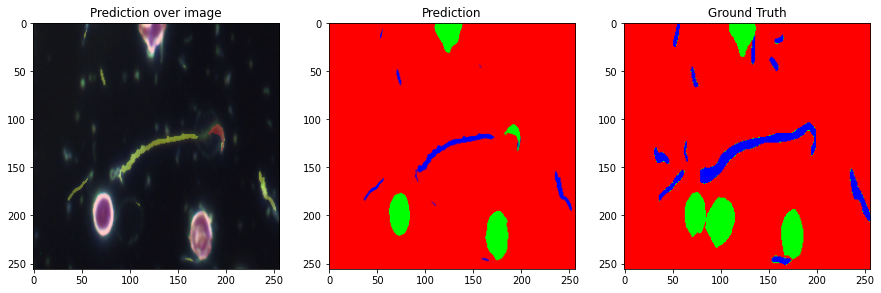

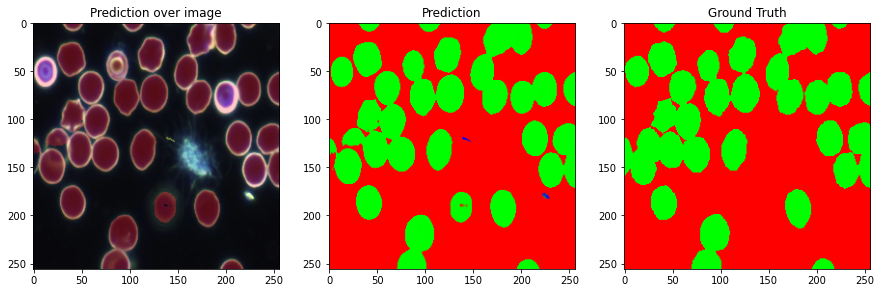

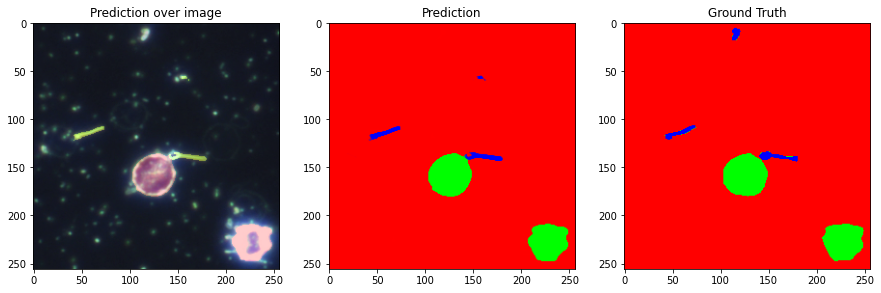

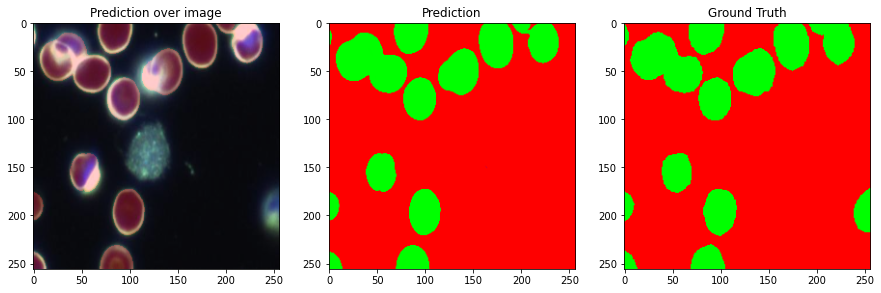

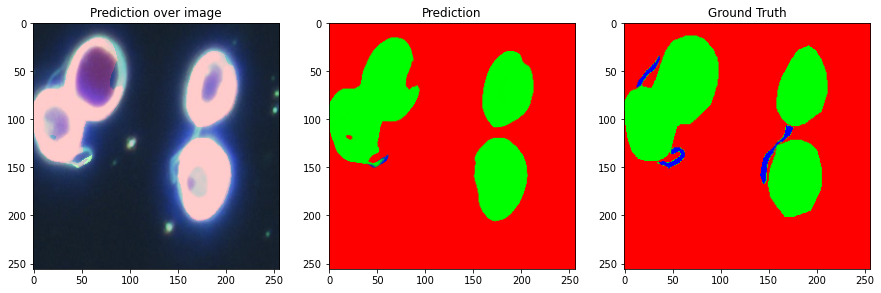

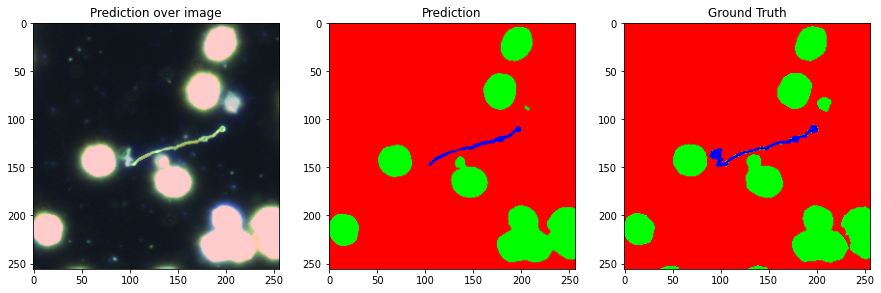

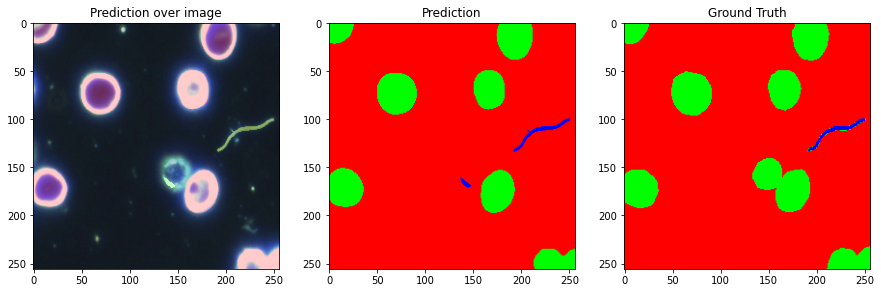

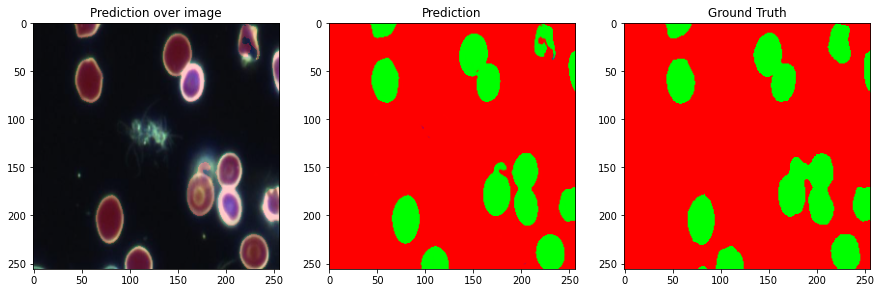

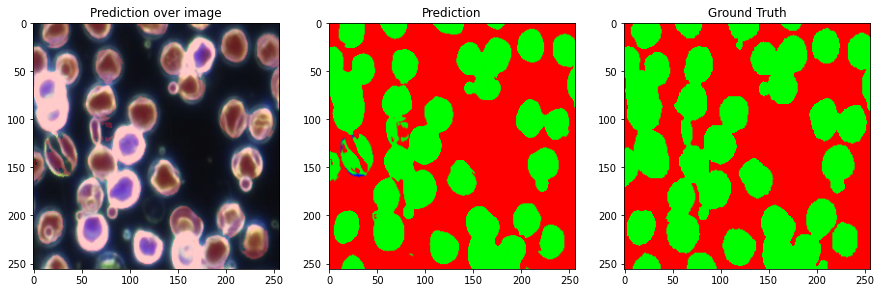

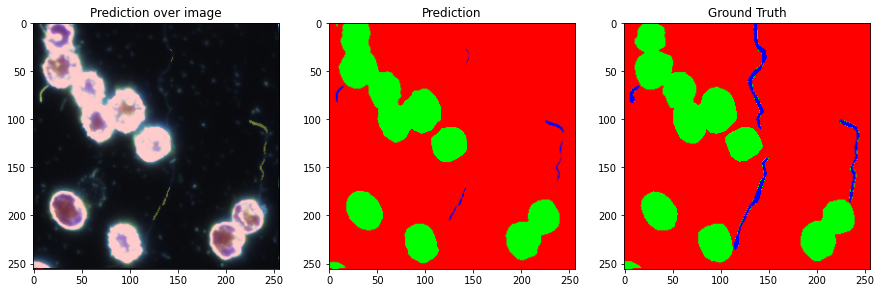

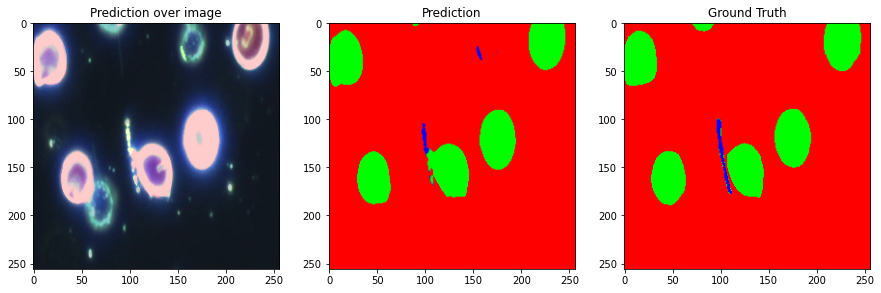

In [29]:
for tuple_img in iterator:
#     print(len(tuple_img[0]))
    predictions = model.predict(tuple_img[0], use_multiprocessing=True)
    for i in range(len(tuple_img[0])):
        binary_rgb(tuple_img[0][i], tuple_img[1][i], predictions[i])
    break

In [30]:
model.save("Unet.h5")